# Machine learning optimization using the Cognitive Assistant component of spark-service

This notebook demonstrates the use of the Cognitive Assistant that is part of Jupyter Notebook running a Python kernel. In this sample, you will use the Cognitive Assistant package to optimize machine learning piplelines for a dataframe you create from a dataset.  Cognitive Assistant will help you select the highest-performing pipelines for your dataframe, tune your chosen pipelines' hyperparameters for further optimization, and generate python code for the optimized pipelines.  The generated code will better assist you with subsequent training of models with your full dataset (and subsequent updates), and with scoring (generating predictions for unlabeled data).

Cognitive assistant currently employs Apache® Spark (PySpark) and SKLearn (Python scikit-learn) analytics on Spark 2.0 and Python 2.7, optionally with feature selection, for classification and regression.

In the first phase, when you invoke startOptimization() on your dataframe, Cognitive Assistant takes your dataframe, samples it, and runs all pipelines with their default parameters, progressively allocating more data to the pipelines that cognitive assistant projects will have the best performance.  This approach allows Cognitive Assistant to quickly identify better-performing pipelines among many, therefore the user does not necessarily need to wait for the entire optimization to complete to select a preferred pipeline.

In the second phase, you invoke hyperParamOptimizer() on the chosen pipeline's ID.  A radial basis function black-box optimization is performed on the adjustable parameters of the pipeline, using your dataframe.  The result is a new pipeline with a new pipeline ID.

In the third phase, you can generate code for your optimized pipeline and populate a notebook cell with it.  Currently, code generation is supported for sklearn classifiers.

The notebook remains interactive during the optimizations. The execution counter and the kernel activity indicator reflect the activity of both the notebook user and the cognitive assistant.

## Contents

This notebook has the following main sections:
1. [One-time setup: Load or update packages](#update)
1. [Download the data](#download)
1. [Format the data for PySpark ML](#format)
1. [Run the cognitive assistant to rank ML pipelines using your dataset, and monitor its progress](#cads)
1. [Use cognitive assistant to optimize hyperparameters of a chosen pipeline for your dataset](#hpo)
1. [Obtain readable/executable code for your chosen pipeline](#readableCode)
1. [Stop cognitive assistant](#shutDown)




<a id="update"></a>
## 1. One-time setup: update sklearn >0.17 and xgboost >= 0.6
This need only be done one time per user.  The packages are stored in your client's home directory under ~/.local

You must restart your kernel (**Kernel** > **Restart**) after these packages are installed.

In [1]:
!pip install --user -U sklearn


Requirement already up-to-date: sklearn in /gpfs/global_fs01/sym_shared/YPProdSpark/user/s1ff-f270fe90e18d9b-af3360558c86/.local/lib/python2.7/site-packages
Requirement already up-to-date: scikit-learn in /gpfs/global_fs01/sym_shared/YPProdSpark/user/s1ff-f270fe90e18d9b-af3360558c86/.local/lib/python2.7/site-packages (from sklearn)


In [2]:
!pip install --user -U xgboost


Requirement already up-to-date: xgboost in /usr/local/src/bluemix_jupyter_bundle.v61/notebook/lib/python2.7/site-packages
Requirement already up-to-date: scikit-learn in /gpfs/global_fs01/sym_shared/YPProdSpark/user/s1ff-f270fe90e18d9b-af3360558c86/.local/lib/python2.7/site-packages (from xgboost)
Requirement already up-to-date: numpy in /usr/local/src/bluemix_jupyter_bundle.v61/notebook/lib/python2.7/site-packages (from xgboost)
Requirement already up-to-date: scipy in /gpfs/global_fs01/sym_shared/YPProdSpark/user/s1ff-f270fe90e18d9b-af3360558c86/.local/lib/python2.7/site-packages (from xgboost)


In [3]:
!pip install --user -U numpy

Requirement already up-to-date: numpy in /usr/local/src/bluemix_jupyter_bundle.v61/notebook/lib/python2.7/site-packages


Reminder: restart your kernel (**Kernel** > **Restart**) after installing these packages, then continue with the next section.

<a id="download"></a>
## 2. Download the data (one time per user, per dataset)

Because cognitive assistant is especially suited to large data sets, in the following step, you'll be retrieving a *portion of a*  large (2.6 GB) .csv file that contains data on HIGGS boson particles. You can modify the cell to get more of or all of the file.

From the description of the data set on the UCI Web site: "The data has been produced using Monte Carlo simulations. The first 21 features (columns 2-22) are kinematic properties measured by the particle detectors in the accelerator. The last seven features are functions of the first 21 features; these are high-level features derived by physicists to help discriminate between the two classes. There is an interest in using deep learning methods to obviate the need for physicists to manually develop such features. Benchmark results using Bayesian Decision Trees from a standard physics package and 5-layer neural networks are presented in the original paper. The last 500,000 examples are used as a test set."

In [4]:
%%bash
#Download a portion of a popular compressed csv dataset.  The target kilobytes of data are specified after '-ge' nine or so lines below
cat << 'EOF' > limited.sh
# optionally you can limit the download rate to wget via --limit-rate=2m
# limiting the rate provides better control of the total amount of data that is downloaded
wget -nv  -O limited.csv.gz --limit-rate=2m https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz &
WGET_PID=$!
while [ `ps $WGET_PID | wc -l ` -eq 2 ] ; do
    sleep 1
    SIZE=`du -k --apparent-size limited.csv.gz | awk '{print \$1}'`
    echo $SIZE kilobytes downloaded
    #modify the target kilobyte download size after -ge below, or comment out the line below to get the whole file
    if [ -e limited.csv.gz ] ; then if [ $SIZE -ge 3500  ] ; then kill -15 $WGET_PID; fi; fi
done
EOF
cat limited.sh

# optionally you can limit the download rate to wget via --limit-rate=2m
# limiting the rate provides better control of the total amount of data that is downloaded
wget -nv  -O limited.csv.gz --limit-rate=2m https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz &
WGET_PID=$!
while [ `ps $WGET_PID | wc -l ` -eq 2 ] ; do
    sleep 1
    SIZE=`du -k --apparent-size limited.csv.gz | awk '{print \$1}'`
    echo $SIZE kilobytes downloaded
    #modify the target kilobyte download size after -ge below, or comment out the line below to get the whole file
    if [ -e limited.csv.gz ] ; then if [ $SIZE -ge 3500  ] ; then kill -15 $WGET_PID; fi; fi
done


In [5]:
!echo "expect an unexpected-end-of-file-message, that is ok if you specified a limited download size"
!bash limited.sh
#an incomplete last line will likely occur in the case of a partial download, and must be discarded
!gunzip -c -q limited.csv.gz | head -n -2 > limited.csv
!echo `wc -l limited.csv` ' complete lines of csv retrieved'

expect an unexpected-end-of-file-message, that is ok if you specified a limited download size
1912 kilobytes downloaded
4032 kilobytes downloaded
limited.sh: line 12: 17952 Terminated              wget -nv -O limited.csv.gz --limit-rate=2m https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz

gzip: limited.csv.gz: unexpected end of file
16117 limited.csv  complete lines of csv retrieved


<a id="format"></a>
## 3. Format the data

Format the data into a Pyspark SQL dataframe consisting of a numeric `label` column and a vector `features` column.

In [6]:
version_list = sc.version.split('.')
major_version = version_list[0]
if int(major_version) == 1:
    from pyspark.mllib.linalg import Vectors
else:
    from pyspark.ml.linalg import Vectors

from pyspark.ml.feature import VectorAssembler

if int(major_version) == 1:
    raise Warning("Spark versions before 2.0 may no longer function with this notebook. Use Kernel... Change Kernel... to select Spark 2.0 ")

In [7]:
df = sqlContext.read.format('com.databricks.spark.csv')\
  .options(header='false', inferschema='true')\
  .load("limited.csv")

In [8]:
allNames = [f.name for f in df.schema.fields]
#FIRST column is the label (unlike many csv where it is the last)
labelName = allNames[0]
print 'labelName ' + labelName
featureNames = [ f.name for f in df.schema.fields if f.name != labelName ]
print 'featureNames=' + str(featureNames)

labelName _c0
featureNames=['_c1', '_c2', '_c3', '_c4', '_c5', '_c6', '_c7', '_c8', '_c9', '_c10', '_c11', '_c12', '_c13', '_c14', '_c15', '_c16', '_c17', '_c18', '_c19', '_c20', '_c21', '_c22', '_c23', '_c24', '_c25', '_c26', '_c27', '_c28']


In [9]:
featureAssembler = VectorAssembler(
    inputCols=featureNames,
    outputCol="features")

In [10]:
#create features (vector) column then select label and features column, with renaming.
inDF=featureAssembler.transform(df).selectExpr(labelName + " as label","features as features")


In [11]:
print inDF

DataFrame[label: double, features: vector]


### 3.1 Remove compressed file

You can clear up space on your filesystem by removing the compressed *limited.csv.gz* file that you downloaded. Because of the deferred computation in Spark, the uncompressed file is accessed later and cannot be erased at this point.

In [12]:
!rm -f limited.csv.gz

<a id="cads"></a>
## 4. Run the cognitive assistant optimization to rank ML pipelines for your data

Before you can use the cognitive assistant, you must import the cognitive_assistant package and then start the assistant.

In [13]:
import cognitive_assistant as cognitive

cognitive_assistant has instantiated 'assistant'


In [14]:
#cognitive.assistant.reconnectAssistant()

In [15]:
#override CADS.conf hyperparameter optimization defaults for demonstration purposes
cadsArgs='-DBBO_MAX_WALL_CLOCK_TIME=300'
#better values for hyperparameter optimization, but will HPO will take too long for a demonstration
#cadsArgs='-DBBO_MAX_WALL_CLOCK_TIME=10000 -DBBO_MAX_EVALUATIONS=350'
#or use CADS.conf defaults:
#cadsArgs=''
cognitive.assistant.startAssistant(cadsArgs=cadsArgs)

Please wait...Cognitive Assistant is starting
WARNING your arguments to startOptimization must be compatible with the cadsArgs you have supplied here.
mario is available and responding
mario is available and responding
cads is available and responding
ok to proceed
Assistant is started.
If you have directly invoked startAssistant() or have just imported cognitive_assistant, you may now invoke startOptimization(<dataFrame>).


### 4.1 Start the cognitive assistant optimization

You invoke the cognitive assistant function by providing it the following information:

-  the name of the data frame
-  the prediction type (default is 'CLASSIFICATION')
    -  Alternatively, specify data frame name and predictionType='REGRESSION'


In [16]:
cognitive.assistant.startOptimization(inDF)

Assistant is determining the optimum pipeline for dataFrame NoNameSpecified with row count= 16117 in background.
To view progress, invoke visualizeProgress().  To stop the optimization and erase the results, invoke stopAssistant().


### 4.2 Monitor the ranking of pipelines as optimization progresses

This code defines a dynamically-updated leaderboard to monitor the progress of optimization in your notebook.


In [17]:
import os
import IPython
from IPython.display import display
import uuid

session = get_ipython().kernel.session
pub_channel = get_ipython().kernel.iopub_socket

def display_init(obj, display_id, update=False):
    data, metadata = get_ipython().display_formatter.format(obj)
    id_data = {'display_id': display_id}
    content = {
        'transient': id_data,
        'metadata': metadata,
        'data': data
    }
    if update:
        display_or_update = 'update_display_data'
    else:
        display_or_update = 'display_data'
    session.send(pub_channel, display_or_update, content, parent=get_ipython().parent_header)

def display_update(obj, display_id):
    return display_init(obj, display_id, update=True)

class UpdatableHTML(object):
    def __init__(self):
        self._display_id = str(uuid.uuid4())
        self.inner_html = ''

    def display(self):
        display_init(obj=IPython.display.HTML(self.inner_html), display_id=self._display_id)
    
    def update(self):
        display_update(obj=IPython.display.HTML(self.inner_html), display_id=self._display_id)

html_widget = UpdatableHTML()
html_widget.display()

import IPython.display, threading, time, requests, json
try:
    from json.decoder import JSONDecodeError
except ImportError:
    JSONDecodeError = ValueError

#todo -- abstract this into a class with start/stop method
stop_draw_table_and_update = False

def draw_table_and_update(header_color, odd_row_color, even_row_color, border_color, rest_api, 
                          feature_headers, feature_ids, num_rows, update_increment):
    while not stop_draw_table_and_update:
        resp = requests.get(rest_api)
        data = ''
        try:
            data = resp.json()
        except JSONDecodeError as e:
            pass
        innerHTML = '<a id="leaderboard"></a>'    
        if len(data) > 0: 
            innerHTML += '<table width="100%"><tr>'
            for header in feature_headers:
                innerHTML += ('<th style="text-align: left; padding-right:15px; border:' + border_color + 
                              ' 1px solid; background: ' + header_color + ';">' + header + '</th>')
            innerHTML += '</tr>'

            rows_to_display = num_rows
            if len(data) < num_rows:
                rows_to_display = len(data)

            for i in range(0, rows_to_display):
                backgroundColor = odd_row_color
                if (i % 2) is 1:
                    backgroundColor = even_row_color

                innerHTML += '<tr>'
                for feature_id in feature_ids:
                    feature_value = str(data[i][feature_id])
                    innerHTML += ('<td style="text-align: left; padding-right:15px; border:' + border_color + 
                                  ' 1px solid; background: ' + backgroundColor + ';">' + feature_value + '</td>')
                innerHTML += '</tr>'
            innerHTML += '</table>'
        else:
            innerHTML += 'Initial performance ranking is pending results from first executions.'
            
        html_widget.inner_html = innerHTML
        html_widget.update()
        time.sleep(update_increment)
    
    if stop_draw_table_and_update:
        print 'Stopping stop_draw_table_and_update thread.'
        
rest_api = 'http://'+str(cognitive.assistant.getConf('cads_host'))+':'+str(cognitive.assistant.getConf('cads_port'))+'/cads/get/AllAlgorithmTrajectoryRank'
feature_headers = ['ID', 'Approach', 'FSCORE [Loss]', 'Data Allocation Pct']
feature_ids = ['AlgorithmTrajectoryUUID', 'AlgorithmExecutionName', 'AlgorithmExecutionValidationPerformanceError','AlgorithmExecutionDataInstancesPercentage']

html_widget = UpdatableHTML()
html_widget.display()
update_interval=9 # seconds
draw_thread = threading.Thread(target = draw_table_and_update, 
                               args = ('#f5f5f5', '#ffffff', '#f0f8ff', '#f8f8ff', rest_api, 
                                       feature_headers, feature_ids, 10, update_interval))
draw_thread.start()

ID,Approach,FSCORE [Loss],Data Allocation Pct
P2,[TH Finished] Data -> FS: -> Sampler -> CL: SklearnJupyterGradientBoostedTree,0.7038 [29.6%],100.0
P41,[TH Finished] Data -> FS: -> Sampler -> CL: SklearnJupyterGradientBoostedTree (Optimized),0.7038 [29.6%],100.0
P15,[TH Finished] Data -> FS: -> Sampler -> CL: JupyterXgboost,0.7016 [29.83%],100.0
P21,[TH Finished] Data -> FS: -> Sampler -> CL: SklearnJupyterRandom Forest,0.7003 [29.98%],100.0
P26,[TH Finished] Data -> FS: SklearnJupyterPercentile -> Sampler -> CL: JupyterXgboost,0.6978 [30.21%],100.0
P3,[TH Finished] Data -> FS: SklearnJupyterPercentile -> Sampler -> CL: SklearnJupyterGradientBoostedTree,0.6964 [30.36%],100.0
P19,[TH Finished] Data -> FS: -> Sampler -> CL: PySpark JupyterGradientBoostedTree,0.6935 [30.65%],100.0
P12,[TH Finished] Data -> FS: SklearnJupyterPercentile -> Sampler -> CL: PySpark JupyterGradientBoostedTree,0.6879 [31.22%],100.0
P14,[TH Finished] Data -> FS: SklearnJupyterPercentile -> Sampler -> CL: SklearnJupyterRandom Forest,0.6838 [31.64%],100.0
P18,[TH Finished] Data -> FS: SklearnJupyterPercentile -> Sampler -> CL: PySpark JupyterRandom Forest,0.6638 [33.49%],100.0


<a id="leaderboard"></a>

In [18]:
#skip this unless you want to modify and restart the leaderboard display
#stop_draw_table_and_update=True
#time.sleep(update_interval)

In [19]:
# raise an exception so that in-order all-cell execution is halted at this cell.  Instruct the user to proceed on a cell-by-cell basis.
raise Warning("Stopping 'Run All' execution at this point to allow time for optimization to progress.  Execute subsequent cells one-at-a-time as needed. ")

Warning: Stopping 'Run All' execution at this point to allow time for optimization to progress.  Execute subsequent cells one-at-a-time as needed. 

### Generate performance curves for all pipelines.  Re-invoke this as many times as you want to update and view current results. An error message can be expected while the optimization is starting up.

top-ranked pipeline:P2
 [TH Finished] Data -> FS:  -> Sampler -> CL: SklearnJupyterGradientBoostedTree 


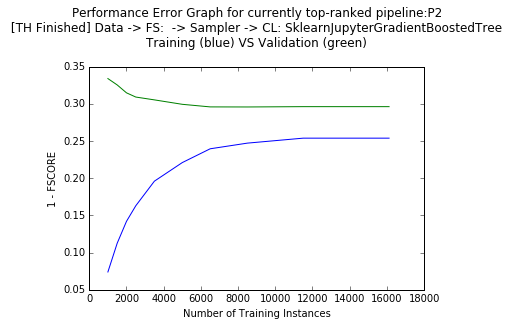

2nd-ranked pipeline:P41
 [TH Finished] Data -> FS:  -> Sampler -> CL: SklearnJupyterGradientBoostedTree (Optimized)


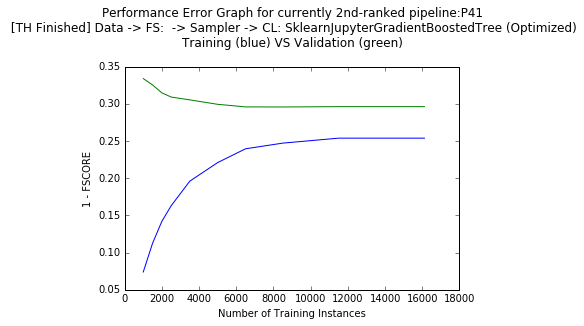

3rd-ranked pipeline:P15
 [TH Finished] Data -> FS:  -> Sampler -> CL: JupyterXgboost


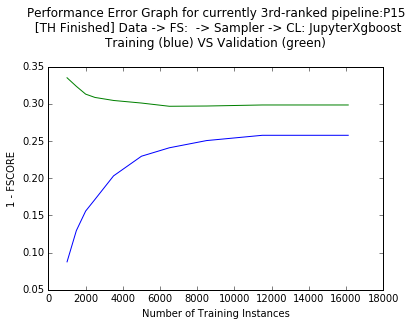

4th-ranked pipeline:P21
 [TH Finished] Data -> FS:  -> Sampler -> CL: SklearnJupyterRandom Forest


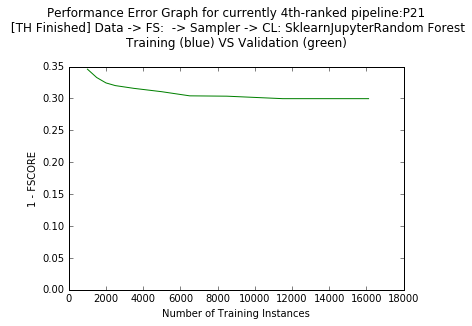

5th-ranked pipeline:P26
 [TH Finished] Data -> FS: SklearnJupyterPercentile -> Sampler -> CL: JupyterXgboost


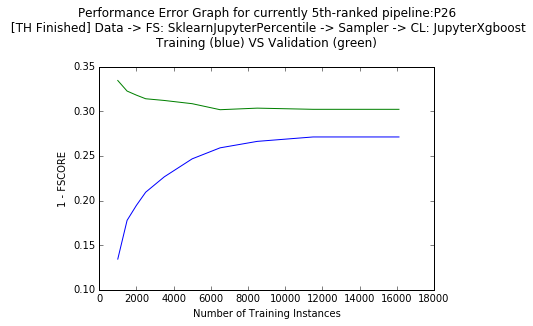

6th-ranked pipeline:P3
 [TH Finished] Data -> FS: SklearnJupyterPercentile -> Sampler -> CL: SklearnJupyterGradientBoostedTree


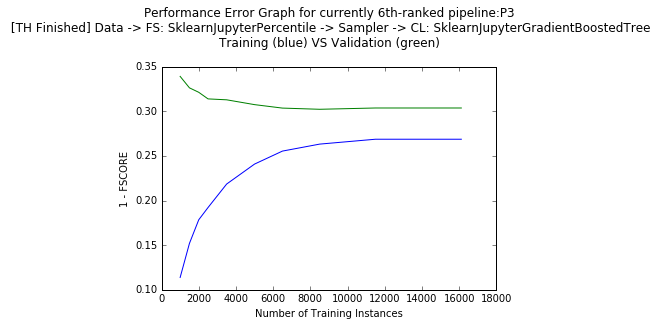

7th-ranked pipeline:P19
 [TH Finished] Data -> FS:  -> Sampler -> CL: PySpark JupyterGradientBoostedTree


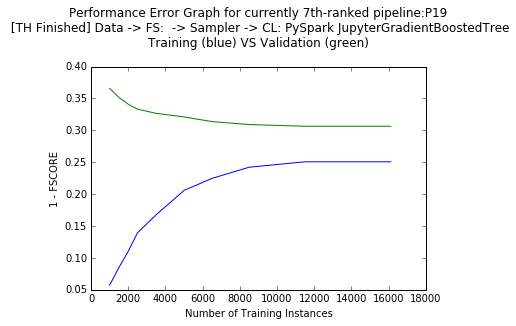

8th-ranked pipeline:P12
 [TH Finished] Data -> FS: SklearnJupyterPercentile -> Sampler -> CL: PySpark JupyterGradientBoostedTree


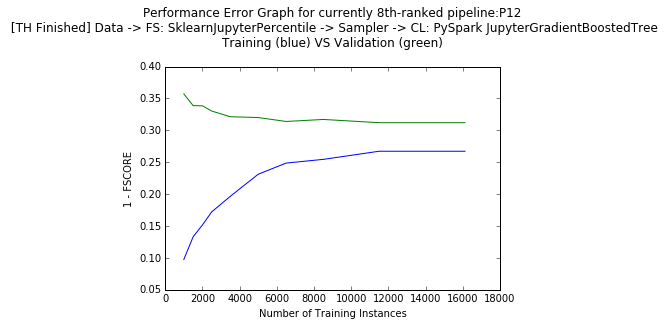

9th-ranked pipeline:P14
 [TH Finished] Data -> FS: SklearnJupyterPercentile -> Sampler -> CL: SklearnJupyterRandom Forest


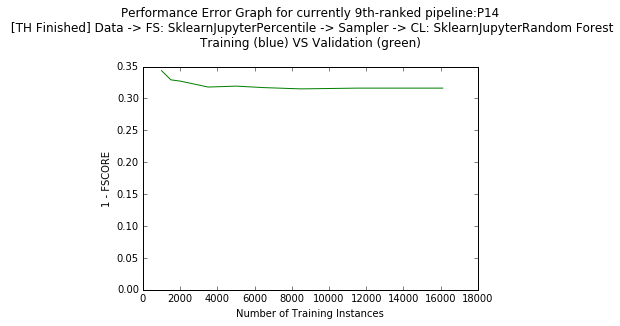

10th-ranked pipeline:P18
 [TH Finished] Data -> FS: SklearnJupyterPercentile -> Sampler -> CL: PySpark JupyterRandom Forest


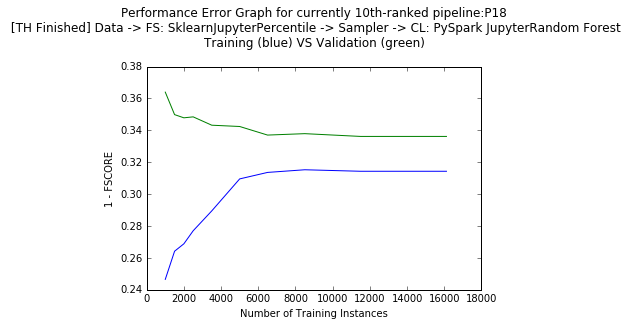

11th-ranked pipeline:P25
 [TH Finished] Data -> FS:  -> Sampler -> CL: PySpark JupyterDecision Tree  [Explainable]


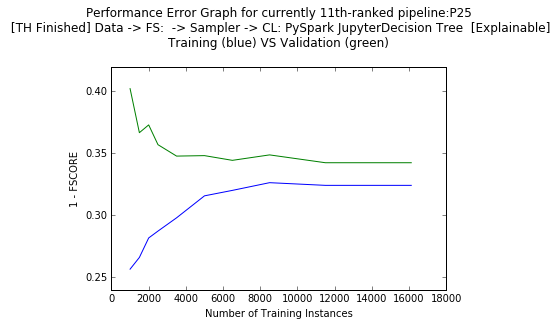

12th-ranked pipeline:P30
 [TH Finished] Data -> FS: SklearnJupyterPercentile -> Sampler -> CL: PySpark JupyterDecision Tree  [Explainable]


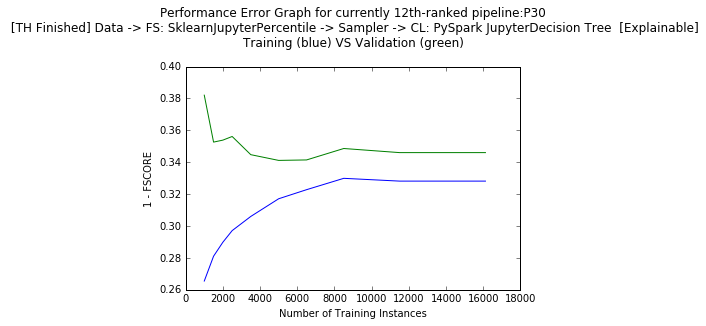

13th-ranked pipeline:P24
 [TH Finished] Data -> FS:  -> Sampler -> CL: SklearnJupyterLogistic Regression L1 [Explainable]


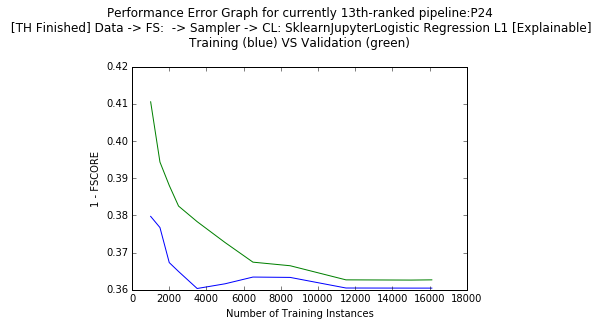

14th-ranked pipeline:P10
 [TH Finished] Data -> FS:  -> Sampler -> CL: SklearnJupyterLogistic Regression L2 [Explainable]


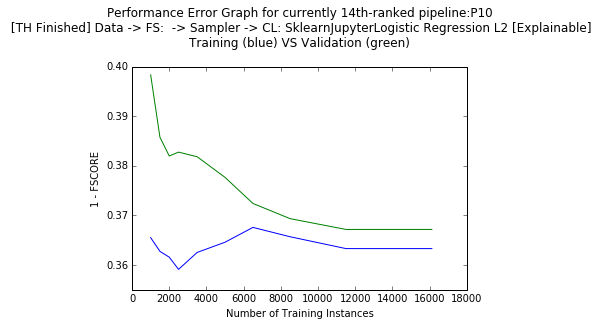

15th-ranked pipeline:P5
 [TH Finished] Data -> FS:  -> Sampler -> CL: SklearnJupyterDecision Tree  [Explainable]


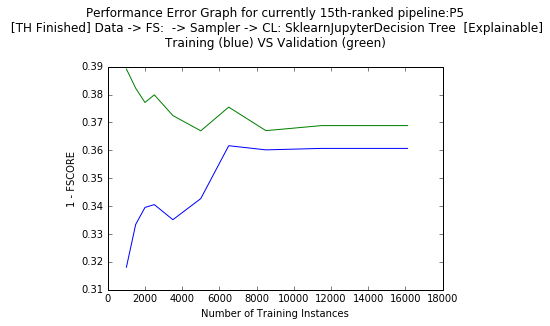

16th-ranked pipeline:P22
 [TH Finished] Data -> FS: SklearnJupyterPercentile -> Sampler -> CL: SklearnJupyterDecision Tree  [Explainable]


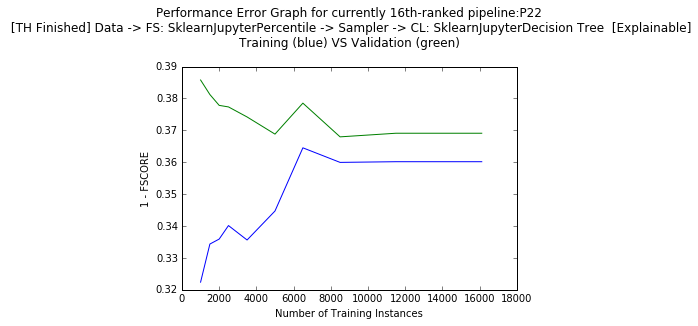

17th-ranked pipeline:P16
 [TH Finished] Data -> FS: SklearnJupyterPercentile -> Sampler -> CL: SklearnJupyterLogistic Regression L1 [Explainable]


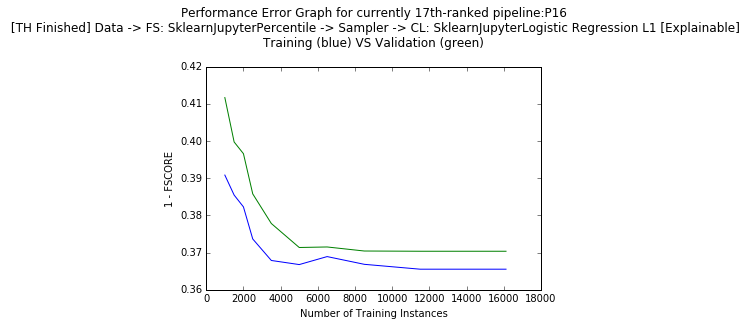

18th-ranked pipeline:P29
 [TH Finished] Data -> FS: SklearnJupyterPercentile -> Sampler -> CL: SklearnJupyterLogistic Regression L2 [Explainable]


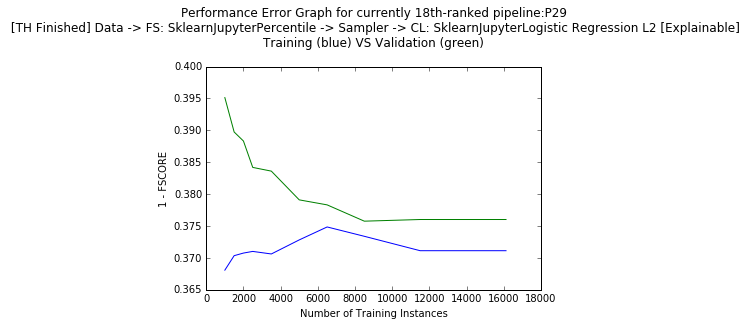

19th-ranked pipeline:P27
 [TH Finished] Data -> FS: SklearnJupyterPercentile -> Sampler -> CL: SklearnJupyterSVMRBF Kernel


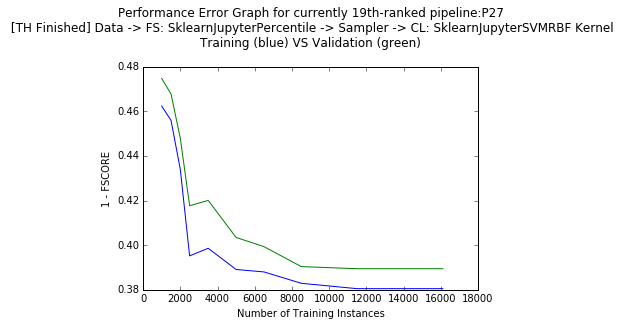

20th-ranked pipeline:P13
 [TH Finished] Data -> FS:  -> Sampler -> CL: PySpark JupyterLogistic Regression [Explainable]


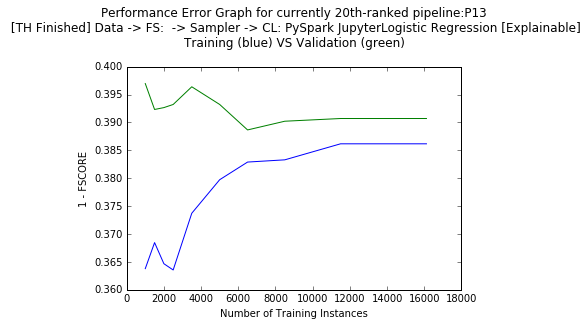

21th-ranked pipeline:P9
 [TH Finished] Data -> FS: SklearnJupyterPercentile -> Sampler -> CL: PySpark JupyterLogistic Regression [Explainable]


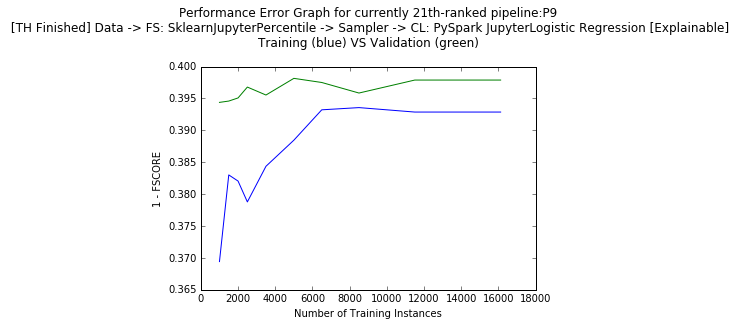

22th-ranked pipeline:P4
 [TH Finished] Data -> FS: SklearnJupyterPercentile -> Sampler -> CL: SklearnJupyterKNearestNeighbors


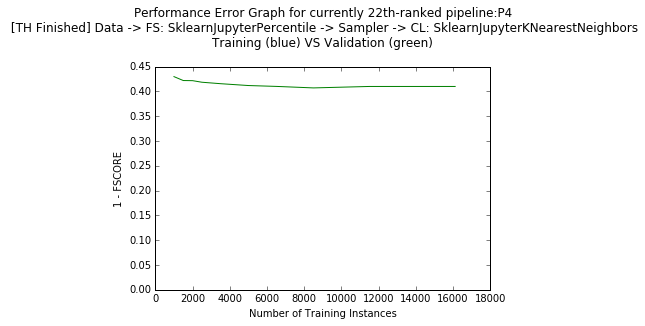

23th-ranked pipeline:P11
 [TH Finished] Data -> FS:  -> Sampler -> CL: SklearnJupyterNaive Bayes


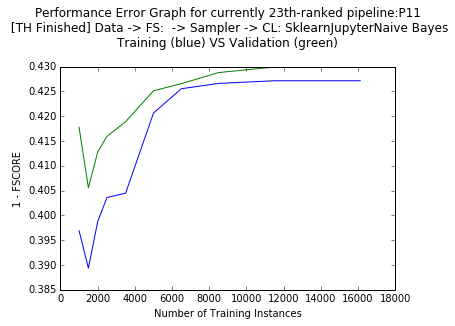

24th-ranked pipeline:P7
 [TH Finished] Data -> FS:  -> Sampler -> CL: SklearnJupyterSVMRBF Kernel


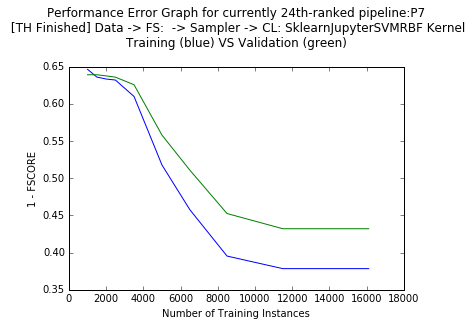

25th-ranked pipeline:P28
 [TH Finished] Data -> FS: SklearnJupyterPercentile -> Sampler -> CL: SklearnJupyterNaive Bayes


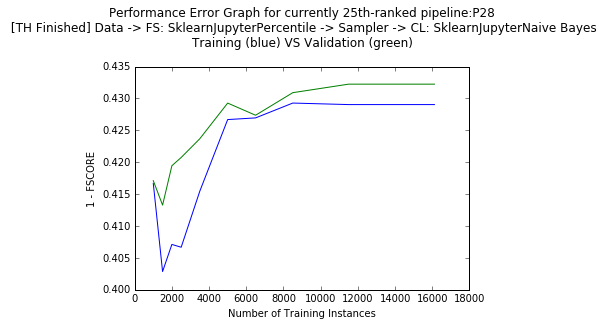

26th-ranked pipeline:P31
 [TH Finished] Data -> FS: SklearnJupyterPercentile -> Sampler -> CL: SklearnJupyterSVMSigmoidKernel


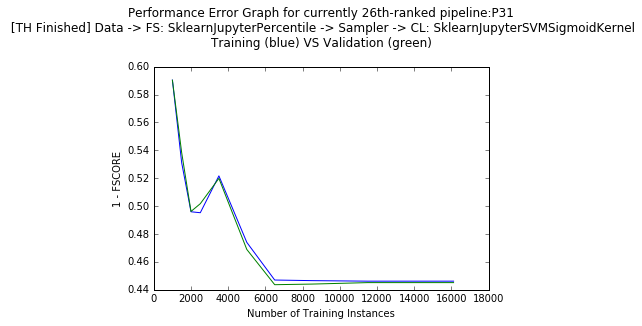

27th-ranked pipeline:P6
 [TH Finished] Data -> FS:  -> Sampler -> CL: SklearnJupyterKNearestNeighbors


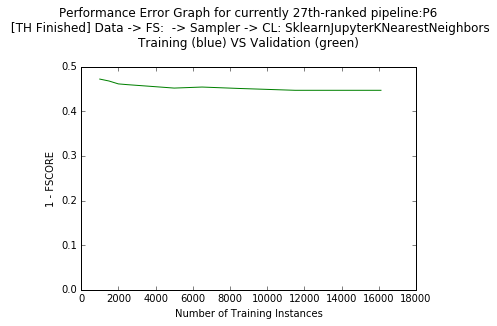

28th-ranked pipeline:P20
 [TH Finished] Data -> FS:  -> Sampler -> CL: SklearnJupyterPerceptron


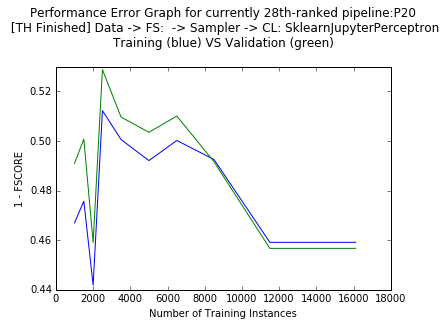

29th-ranked pipeline:P17
 [TH Finished] Data -> FS:  -> Sampler -> CL: SklearnJupyterSVMSigmoidKernel


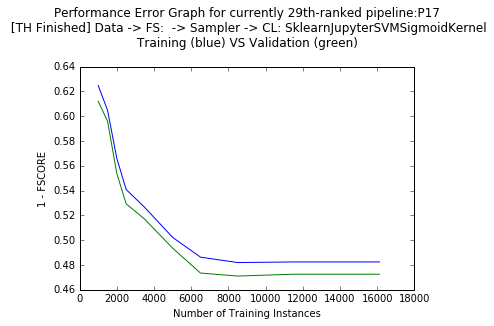

30th-ranked pipeline:P8
 [TH Finished] Data -> FS: SklearnJupyterPercentile -> Sampler -> CL: SklearnJupyterPerceptron


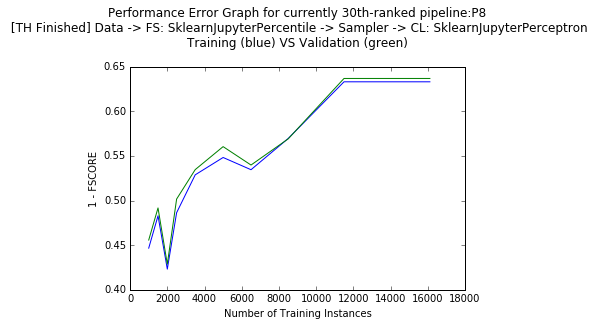

{'algorithmTrajectoryUUID': u'--'}
no json for rank 31
AlgorithmTrajectoryUUID not found: --


In [8840]:
cognitive.assistant.visualizeProgress()

### 4.3 Do a quick check of CPU - Optional

To further check on the progress of your optimization, you can can run the following command to display CPU activity and the number of processes that are running.

In [ ]:
!top -u $USER -n 1

### 4.4 Continue your work!

Cognitive assistant is working in the background so you can continue to use your notebook interactively as the optimization progresses.  This can include additional optimization and code generation as detailed below:


<a id="hpo"></a>
## 5 Optimize hyperparameters for your chosen pipeline

If you like the evolving performance evaluation of a pipeline, you do not need to wait for CADS ranking of ML algorithms to complete.  You can ask cognitive assistant to optimize the hyperparameters for your chosen pipeline (identified by pipeline ID P<nn>) at any time.  Black-Box Optimization can take considerable time, which can be controlled by the startup parameters first given to startAssistant().

In [884]:
cognitive.assistant.hyperParamOptimizer(pipelineID='P2')

You can periodically return to the visualizeProgress() method to see the status of the HPO.  The original pipeline will have the additional label "Optimizing" while the optimization is in progress and the new pipeline will be labeled "Optimized" when HPO is complete.

<a id="readableCode"></a>
## 6 Obtain "readable code" for your chosen pipeline

To deploy the pipeline outside of cognitive assistant, you can request a "readable code" representation of the pipeline identified by ID.  Remember that the hyperparameter-optimized pipeline is given its own pipeline ID, should you want the generated code to match its parameterization.  This code is emitted directly into the notebook cell for you, the user, to use as you please. The query is done asynchronously in a two-step process in separate notebook cells to avoid deadlocking the kernel.

The emitted code is intended to run with minimum necessary user modifications (you will need to provide the data frame names you wish to operate upon). Other minor fixups may be necessary.  Currently in cognitive-assistant, "readable code" output is limited to pipelines with sklearn classifiers.

In [ ]:
#fixups for generated code to run as-is in this notebook.  Modify to suit.
gini='gini'
trainDF=inDF

In [8837]:
cell=cognitive.assistant.generateCode('P41')

In [ ]:
# code for pipeline P41
from numpy import array as nparray
from pyspark.sql import Row
from pyspark.sql import SQLContext
def np2df(npY,npX):
       rddResult = sc.parallelize(zip(npY, npX))
       dfResult = sqlContext.createDataFrame(rddResult.map(lambda r:Row(label=float(r[0]), features=Vectors.dense(r[1]))))     
       return dfResult;

def df2npF(df, featuresCol="features"):
        features = df.select(featuresCol)
        features2 = features.withColumnRenamed(featuresCol, "my_column")
        X = nparray([f.my_column.toArray() for f in features2.collect()])
        return X;

def df2npL(df, labelCol="label"):
        label = df.select(labelCol)
        Y = nparray([l.label for l in label.collect()])
        return Y;

from sklearn.ensemble import GradientBoostingClassifier
clf =  GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=100, subsample=1.0, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, init=None, random_state=None, max_features=1.0, verbose=0, max_leaf_nodes=None, warm_start=False)
clf.fit(df2npF(df=trainDF), df2npL(df=trainDF))



In [8838]:
cell.generateCell()

In [ ]:
# code for pipeline P41
from numpy import array as nparray
from pyspark.sql import Row
from pyspark.sql import SQLContext
def np2df(npY,npX):
       rddResult = sc.parallelize(zip(npY, npX))
       dfResult = sqlContext.createDataFrame(rddResult.map(lambda r:Row(label=float(r[0]), features=Vectors.dense(r[1]))))     
       return dfResult;

def df2npF(df, featuresCol="features"):
        features = df.select(featuresCol)
        features2 = features.withColumnRenamed(featuresCol, "my_column")
        X = nparray([f.my_column.toArray() for f in features2.collect()])
        return X;

def df2npL(df, labelCol="label"):
        label = df.select(labelCol)
        Y = nparray([l.label for l in label.collect()])
        return Y;

from sklearn.ensemble import GradientBoostingClassifier
clf =  GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=100, subsample=1.0, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, init=None, random_state=None, max_features=1.0, verbose=0, max_leaf_nodes=None, warm_start=False)
clf.fit(df2npF(df=trainDF), df2npL(df=trainDF))



In [8839]:
cell2=cognitive.assistant.generateCode('P2')

In [ ]:
# code for pipeline P2
from numpy import array as nparray
from pyspark.sql import Row
from pyspark.sql import SQLContext
def np2df(npY,npX):
       rddResult = sc.parallelize(zip(npY, npX))
       dfResult = sqlContext.createDataFrame(rddResult.map(lambda r:Row(label=float(r[0]), features=Vectors.dense(r[1]))))     
       return dfResult;

def df2npF(df, featuresCol="features"):
        features = df.select(featuresCol)
        features2 = features.withColumnRenamed(featuresCol, "my_column")
        X = nparray([f.my_column.toArray() for f in features2.collect()])
        return X;

def df2npL(df, labelCol="label"):
        label = df.select(labelCol)
        Y = nparray([l.label for l in label.collect()])
        return Y;

from sklearn.ensemble import GradientBoostingClassifier
clf =  GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=100, subsample=1.0, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, init=None, random_state=None, max_features=1.0, verbose=0, max_leaf_nodes=None, warm_start=False)
clf.fit(df2npF(df=trainDF), df2npL(df=trainDF))



In [ ]:
cell2.generateCell()

<a id="shutdown"></a>
## 6. Stop the cognitive assistant process

When optimization has completed or progressed to an acceptable point, the cognitive assistant can be stopped by running the following command:

In [ ]:
cognitive.assistant.stopAssistant()

## Summary

You downloaded and formatted a publicly available data set and then used the cognitive assistant to identify a high-performance pipeline and adjust its hyperparameters for your dataset.  You then used cognitive-assistant to generate code (this cognitive-assistant feature is currently limited to sklearn classifiers) so that you can invoke these pipelines independently of cognitive-assistant. Congratulations!

## Authors

**Peter D. Kirchner**, PhD (Electrical Engineering), is a Research Scientist persuing computer science research in machine learning and cloud computing at the IBM Thomas J. Watson Research Center. He is presently engaged in cognitive automation of data science workflow to assist data scientists, focused on cloud-based deployments and scalability.

**Gregory Bramble** is a Research Software Engineer at the IBM T.J. Watson Research Center. Greg has 10+ years development experience in industry and research, and has built several applications which have achieved widespread use. Greg studied Computer Science and Mathematics at Columbia University where his advanced coursework included AI, Graph Theory, and Algorithms.

**Mike Sochka** is a content designer focusing on IBM Data Science Experience and Watson Machine Learning. 

***
### References

Ashish Sabharwal, Horst Samulowitz, Gerald Tesauro, "Selecting Near-Optimal Learners via Incremental Data Allocation". Proc. 30th AAAI pp. 2007-15 (2016) http://dl.acm.org/citation.cfm?id=3016179

Biem, A., Butrico, M., Feblowitz, M., Klinger, T., Malitsky, Y., Ng, K., Perer, A., and Reddy, C., Riabov, A., Samulowitz, H., Sow, D., Tesauro, G., Turaga, D. "Towards Cognitive Automation of Data Science".  Proc. 29th AAAI pp. 4268-9 (2015) http://dl.acm.org/citation.cfm?id=2888116.2888360

Costa, A., Nannicini, G. "RBFOpt: an open-source library for black-box optimization with costly function evaluations" Optimization Online https://pdfs.semanticscholar.org/6bdb/d2de4988fab315bc7e6ec0cd14ed3ae8c018.pdf (2014)

Baldi, P., P. Sadowski, and D. Whiteson. “Searching for Exotic Particles in High-energy Physics with Deep Learning.” Nature Communications 5 (July 2, 2014).

Lichman, M. (2013). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

Copyright © 2017 IBM. This notebook and its source code are released under the terms of the MIT License.

 [If you landed here from 'Run All' cells, you can navigate to the leaderboard](#leaderboard)